# Load our video file into memory

Welcome to foosbot

In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

In [2]:
from __future__ import print_function


from video_file import *

import importlib
try:
    importlib.reload(video_file)
except:
    pass

import cv2
import sys
import os
import csv
import numpy as np
from random import randint
from random import shuffle

from PIL import Image
import imageio
import itertools as it

import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)


# Create the image transformer
transformer = VideoTransform( zoom_range=0.1, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range= 0.1, fill_mode='nearest', vertical_flip=False, horizontal_flip=True, horizontal_flip_invert_indices = [], horizontal_flip_reverse_indices = [0,1,2], data_format='channels_last' )


# Paths relative to current python file.
data_path  = ".\\..\\..\\TrainingData\\Processed\\\AmateurDefenderLonger\\Result2\\settings.tsv"

Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0


In [3]:
print("Opening training frames from config %s." % (data_path))
position_rel_indexes = [3] # Predict rod position in 3 frames

number_of_frames = 3
frame_rel_indexes = []
for i in range(number_of_frames):
    frame_rel_indexes += [i - number_of_frames + 1]

pp.pprint(frame_rel_indexes)
#frame_rel_indexes = [-4, -3, -2, -1, 0] # Use 5 frames as input


training = TrainingInput(transformer, data_path, position_rel_indexes, frame_rel_indexes, 0.2)


Opening training frames from config .\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\settings.tsv.
[-2, -1, 0]
Creating training chunk from .\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\chunk0.avi
.\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\chunk0.avi
(54, 100, 3)
added 15032 new frames for a total of 15032
Creating training chunk from .\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\chunk1.avi
.\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\chunk1.avi
(54, 100, 3)
added 22343 new frames for a total of 37375
Creating training chunk from .\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\chunk2.avi
.\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\chunk2.avi
(54, 100, 3)
added 10697 new frames for a total of 48072
Creating training chunk from .\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\chunk3.avi
.\..\..\TrainingData\Processed\\AmateurDefenderLonger\Result2\chunk3.avi
(54, 

In [4]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g



# Define our training and validation iterators
@threadsafe_generator
def TrainGen(model, training):
    while True:
        #print("TrainGen restarting training input.")
        model.reset_states()
        training.move_first_training_frame()
        (frames, output, reset_memory) = training.get_next_training_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_training_frame()
            
            if reset_memory or frames is None:
                model.reset_states()
                
@threadsafe_generator
def ValidateGen(model, training):
    while True:
        #print("Validation restarting training input.")
        model.reset_states()
        training.move_first_validation_frame()
        (frames, output, reset_memory) = training.get_next_validation_frame()
        while frames is not None:
            yield (frames, output)
            (frames, output, reset_memory) = training.get_next_validation_frame()
            
            if reset_memory or frames is None:
                model.reset_states()

# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, model, training):
    gen = TrainGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[1] # Teach it to control the 2-bar
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

@threadsafe_generator
def ValidateBatchGen(batch_size, model, training):
    gen = ValidateGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[1] # Teach it to control the 2-bar
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
# Generators for training the position
@threadsafe_generator
def TrainBatchGen2(batch_size, model, training):
    gen = TrainGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Teach it to control the 2-bar
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

@threadsafe_generator
def ValidateBatchGen2(batch_size, model, training):
    gen = ValidateGen(model, training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, training.depth, training.height, training.width, training.channels), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 1), dtype=np.float32)
        for i in range(batch_size):
            (frames, output) = next(gen)
            batch_frames[i,:,:,:,:] = frames
            batch_outputs[i,:] = output[0] # Teach it to control the 2-bar
            #batch_outputs[i,:] = output[3:6] - output[0:3] # Train the difference in the three rod positions as output
            #batch_outputs[i,:] = output
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
    
# Helper function to plot our validation result
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline


def plot_validate(generator, model, count, name):
    #plot_validate(ValidateBatchGen(batch_size, model), model, 2000, "Position prediction")
    
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    #(frames, outputs_true) = next(ValidateBatchGen(2000))
    #frames = np.squeeze(frames, axis=(1,))
    #validate_in, validate_out
    #frames = validate_in
    #outputs_true =validate_out
    
    print("Predicted.")
    
    
    pp.pprint(outputs_true)
    pp.pprint(outputs_predicted)
    
    
    #plt.figure(figsize=(8,30))
    plt.figure()
    
    #plt.subplot(111)
    plt.plot(range(count),outputs_true[0:count,0], range(count),outputs_predicted[0:count,0] )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)
    
    
    
    
    #plt.figure(figsize=(8,30))
    #plt.subplot(111)
    plt.figure()
    
    true, predicted = zip(*sorted(zip(outputs_true[0:count,0], outputs_predicted[0:count,0])))
    plt.plot(range(count),true, range(count),predicted )
    plt.ylabel("Rod 1: %s" % name)
    plt.title("First 200 output recordings")
    plt.grid(True)

    
    
    plt.show()
          
def mse(y_true, y_pred):
    return K.square(y_pred - y_true)*0.001 # Hackjob so Keras iterations show exponential value of MSE to get precision.


def run_train(model, batch_size, training, lr, start_epoch, num_epochs, WEIGHTS_FNAME, MODELS_FNAME, plot_frequency):
    model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
                  loss='mean_squared_error',
                  metrics=[mse])
    batches_training_per_epoch = int(training.get_training_count() / batch_size)
    batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
    
    print("Starting at lr=%f" % lr)
    print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
    stop = False
    model.reset_states()
    for epoch in range(start_epoch, start_epoch + num_epochs):
        try:
            model.fit_generator(TrainBatchGen(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=10, validation_data=ValidateBatchGen(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
            model.save_weights(WEIGHTS_FNAME % epoch)
            model.save(MODELS_FNAME % epoch)
            if epoch % plot_frequency == 0:
                plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Position prediction")
            print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
        except KeyboardInterrupt:
            print("\r\nUser stopped the training.")
            stop = True
            break

    return (epoch+1, stop)

def run_train2(model, batch_size, training, lr, start_epoch, num_epochs, WEIGHTS_FNAME, MODELS_FNAME, plot_frequency):
    model.compile(optimizer=keras.optimizers.RMSprop(lr=lr),
                  loss='mean_squared_error',
                  metrics=[mse])
    batches_training_per_epoch = int(training.get_training_count() / batch_size)
    batches_validation_per_epoch = int(training.get_validation_count() / batch_size)
    
    print("Starting at lr=%f" % lr)
    print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
    stop = False
    model.reset_states()
    for epoch in range(start_epoch, start_epoch + num_epochs):
        try:
            model.fit_generator(TrainBatchGen2(batch_size, model, training), batches_training_per_epoch, epochs=epoch+1, verbose=1, callbacks=None, class_weight=None, max_q_size=10, workers=10, validation_data=ValidateBatchGen2(batch_size, model, training), validation_steps = batches_validation_per_epoch, pickle_safe=False, initial_epoch=epoch)
            model.save_weights(WEIGHTS_FNAME % epoch)
            model.save(MODELS_FNAME % epoch)
            if epoch % plot_frequency == 0:
                plot_validate(ValidateBatchGen2(batch_size, model, training), model, 2000, "Position prediction")
            print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)
        except KeyboardInterrupt:
            print("\r\nUser stopped the training.")
            stop = True
            break

    return (epoch+1, stop)

# Input training frame

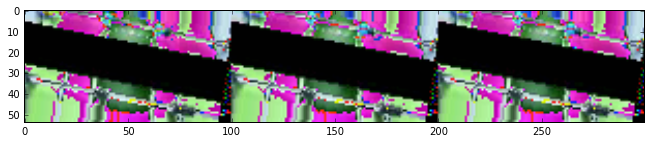

[0.16865, 0.30814, 0.130743]


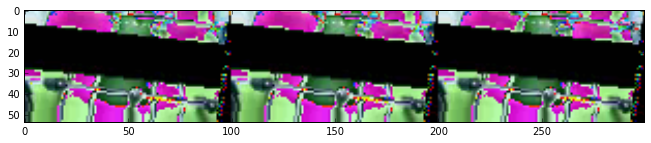

[0.580145, 0.350822, 0.431442]


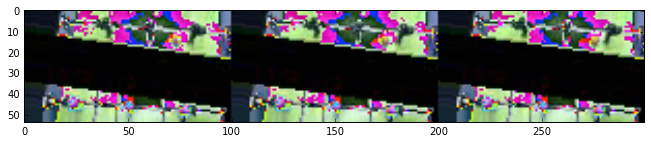

[0.279492, 0.157145, 0.328842]


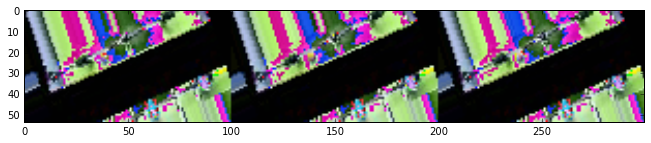

[0.428495, 0.758812, 0.672366]


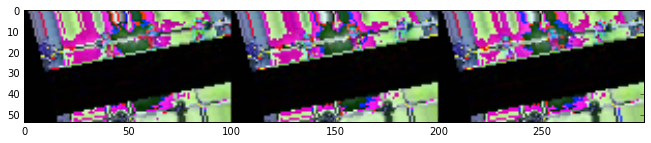

[0.9836633, 0.858634, 0.4615]


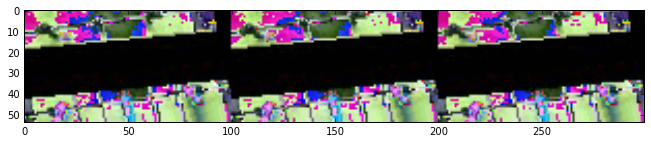

[0.428758, 0.139583, 0.120313]


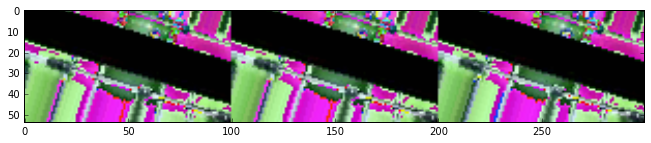

[0.544621, 0.365633, 0.136306]


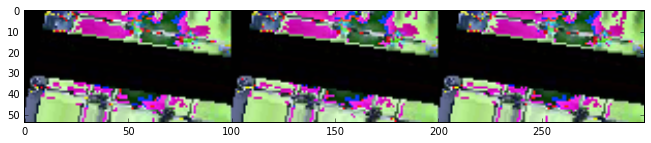

[0.9416391, 0.850862, 0.872258]


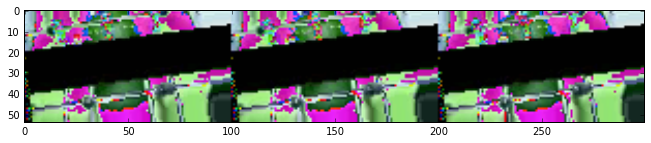

[0.33812200000000003, 0.134772, 0.5113]


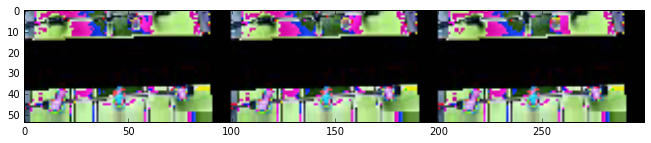

[0.446761, 0.936443, 0.661483]
Shape of training input:
(3, 54, 100, 3)
Shape of training output:
(3,)
Corresponding Positions:
[0.446761, 0.936443, 0.661483]


In [5]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
%matplotlib inline

training.move_first_training_frame()

for k in range(10):
    (frame, position, reset) = training.get_next_training_frame()
    data = np.zeros(shape=(np.shape(frame)[1], np.shape(frame)[2] * np.shape(frame)[0], 3), dtype=np.float32)
    for i in range(np.shape(frame)[0]):
        tmp = frame[i,:,:,:]
        data[:,i*np.shape(frame)[2]:(i+1)*np.shape(frame)[2],:] = tmp


    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(data)
    plt.show()
    pp.pprint(position)

training.move_first_training_frame()

print("Shape of training input:")
pp.pprint(np.shape(frame))

print("Shape of training output:")
pp.pprint(np.shape(position))

print("Corresponding Positions:")
pd.DataFrame(position)
pp.pprint(position)




# Specify the model structure we will use

In [6]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = training.height
image_width        = training.width
image_depth        = training.depth
image_channels     = training.channels
output_size        = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 60

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_depth, image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

# Build a functional model design
inputs = Input(shape=(number_of_frames, image_height, image_width, image_channels,),
              name="Input")
x = Conv3D(cnn_kernel_count,
           kernel_size = (3, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (3, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (3, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (3, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling3D( pool_size=(3, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = Conv3D(cnn_kernel_count,
           kernel_size = (1, 3, 3),
           padding = "same",
           activation = "relu",
           name = "conv3d_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling3D( pool_size=(1, 1, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1




#x = Flatten()(x)
#x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)
x = Flatten()(x)


x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(1, activation='linear',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\TwoBar\\pos_cnn_weights_%i.hdf'
MODELS_FNAME = '.\\TwoBar\\pos_cnn_models_%i.h5'


'Input shape without batches:'
(3, 54, 100, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 3, 54, 100, 3)     0         
_________________________________________________________________
conv3d_0 (Conv3D)            (None, 3, 54, 100, 60)    4920      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 54, 100, 60)    97260     
_________________________________________________________________
max_pooling3d_0 (MaxPooling3 (None, 3, 27, 50, 60)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 27, 50, 60)     97260     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 27, 50, 60)     97260     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 

# Train our model to identify the rod positions

Starting at lr=0.000500
Batch size 40: 1575 training batches, 393 validation batches
Epoch 1/1
1575/1575 [==============================] - 1073s - loss: 0.0688 - mse: 6.8797e-05 - val_loss: 0.0111 - val_mse: 1.1064e-05
Predicted.
array([[ 0.72248203],
       [ 0.38032401],
       [ 0.07463   ],
       ..., 
       [ 0.57809299],
       [ 0.465956  ],
       [ 0.89312702]], dtype=float32)
array([[ 0.68790263],
       [ 0.35230374],
       [ 0.41578835],
       ..., 
       [ 0.62157059],
       [ 0.55461454],
       [ 0.71940887]], dtype=float32)


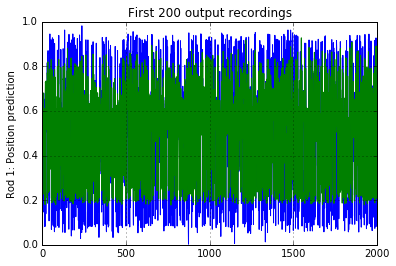

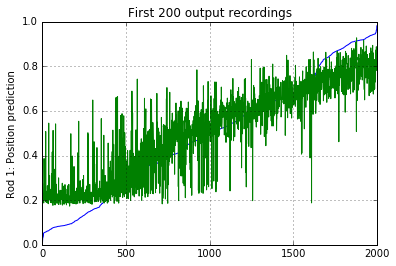

Wrote model to .\TwoBar\pos_cnn_weights_0.hdf
Epoch 2/2
1575/1575 [==============================] - 1062s - loss: 0.0137 - mse: 1.3710e-05 - val_loss: 0.0065 - val_mse: 6.4866e-06
Predicted.
array([[ 0.42230299],
       [ 0.73805499],
       [ 0.58683902],
       ..., 
       [ 0.65288597],
       [ 0.28469399],
       [ 0.65469998]], dtype=float32)
array([[ 0.45254546],
       [ 0.75084782],
       [ 0.5356462 ],
       ..., 
       [ 0.77788281],
       [ 0.28960994],
       [ 0.65120685]], dtype=float32)


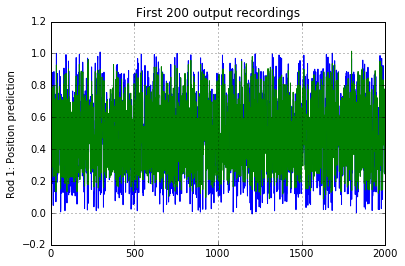

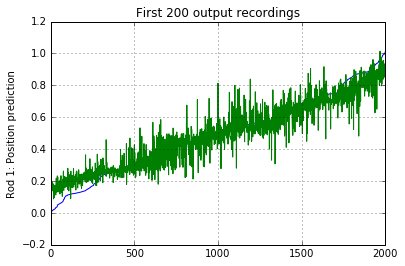

Wrote model to .\TwoBar\pos_cnn_weights_1.hdf
Epoch 3/3
1575/1575 [==============================] - 1063s - loss: 0.0105 - mse: 1.0500e-05 - val_loss: 0.0071 - val_mse: 7.1239e-06
Predicted.
array([[ 0.57769698],
       [ 0.73805499],
       [ 0.41316101],
       ..., 
       [ 0.347114  ],
       [ 0.71530598],
       [ 0.34529999]], dtype=float32)
array([[ 0.55064458],
       [ 0.74028838],
       [ 0.41516879],
       ..., 
       [ 0.31290185],
       [ 0.66638929],
       [ 0.38088644]], dtype=float32)


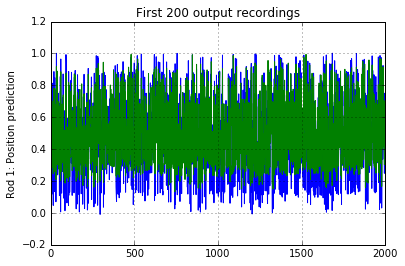

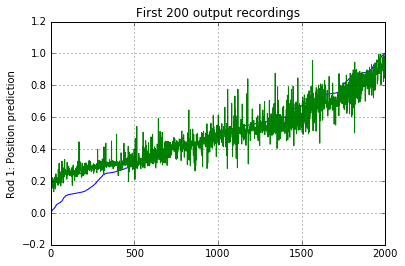

Wrote model to .\TwoBar\pos_cnn_weights_2.hdf
Epoch 4/4
1575/1575 [==============================] - 1060s - loss: 0.0094 - mse: 9.4166e-06 - val_loss: 0.0062 - val_mse: 6.1896e-06
Predicted.
array([[ 0.91940701],
       [ 0.87700099],
       [ 0.56555599],
       ..., 
       [ 0.46289501],
       [ 0.55112398],
       [ 0.087348  ]], dtype=float32)
array([[ 0.88025749],
       [ 0.73152626],
       [ 0.53653097],
       ..., 
       [ 0.41783598],
       [ 0.53088844],
       [ 0.17965741]], dtype=float32)


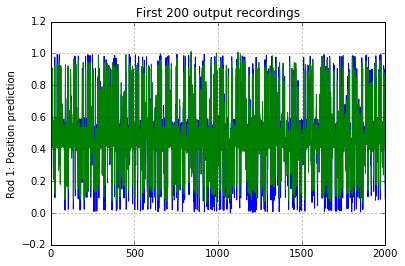

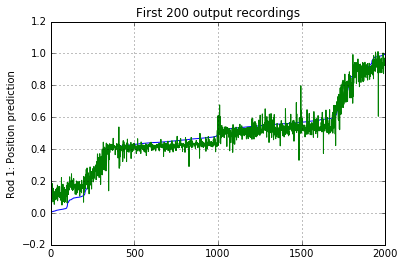

Wrote model to .\TwoBar\pos_cnn_weights_3.hdf
Starting at lr=0.000500
Batch size 40: 1575 training batches, 393 validation batches
Epoch 5/5
1575/1575 [==============================] - 1063s - loss: 0.0629 - mse: 6.2939e-05 - val_loss: 0.0665 - val_mse: 6.6511e-05
Predicted.
array([[ 0.0517868 ],
       [ 0.41973901],
       [ 0.16602901],
       ..., 
       [ 0.876472  ],
       [ 0.886796  ],
       [ 0.40378499]], dtype=float32)
array([[ 0.25171781],
       [ 0.27622533],
       [ 0.29897159],
       ..., 
       [ 0.61398256],
       [ 0.71831101],
       [ 0.41791683]], dtype=float32)


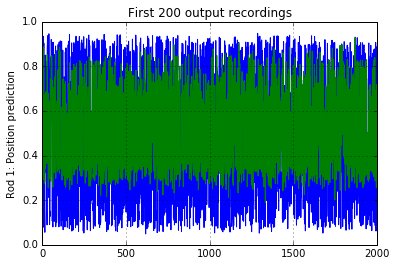

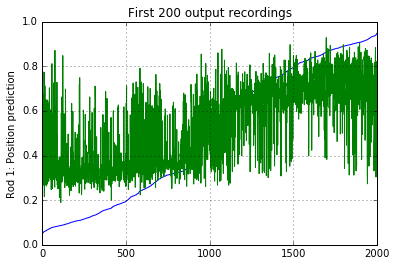

Wrote model to .\TwoBar\pos_cnn_weights_4.hdf
Epoch 6/6
1575/1575 [==============================] - 1067s - loss: 0.0515 - mse: 5.1546e-05 - val_loss: 0.0437 - val_mse: 4.3728e-05
Predicted.
array([[ 0.16193099],
       [ 0.244148  ],
       [ 0.078408  ],
       ..., 
       [ 0.063152  ],
       [ 0.69460702],
       [ 0.89489198]], dtype=float32)
array([[ 0.27843237],
       [ 0.35888818],
       [ 0.27154657],
       ..., 
       [ 0.34541842],
       [ 0.62254453],
       [ 0.7388882 ]], dtype=float32)


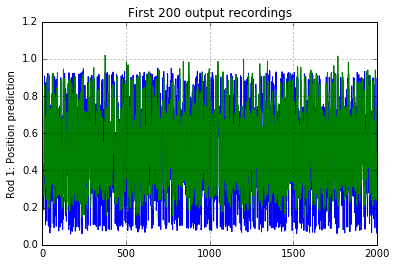

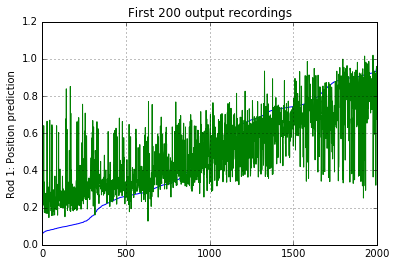

Wrote model to .\TwoBar\pos_cnn_weights_5.hdf
Epoch 7/7
1575/1575 [==============================] - 1061s - loss: 0.0435 - mse: 4.3544e-05 - val_loss: 0.0375 - val_mse: 3.7471e-05
Predicted.
array([[ 0.127014  ],
       [ 0.73420697],
       [ 0.280132  ],
       ..., 
       [ 0.28577501],
       [ 0.27891999],
       [ 0.62249702]], dtype=float32)
array([[ 0.60388207],
       [ 0.65342617],
       [ 0.379188  ],
       ..., 
       [ 0.31077474],
       [ 0.65495634],
       [ 0.58115369]], dtype=float32)


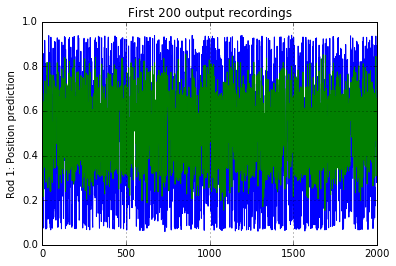

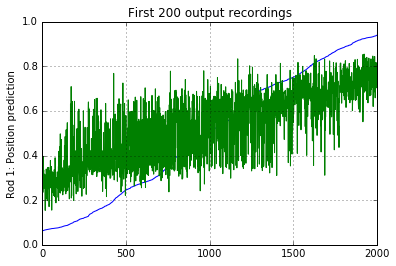

Wrote model to .\TwoBar\pos_cnn_weights_6.hdf
Epoch 8/8
1575/1575 [==============================] - 1061s - loss: 0.0376 - mse: 3.7555e-05 - val_loss: 0.0331 - val_mse: 3.3063e-05
Predicted.
array([[ 0.127014  ],
       [ 0.73420697],
       [ 0.719868  ],
       ..., 
       [ 0.71422499],
       [ 0.27891999],
       [ 0.62249702]], dtype=float32)
array([[ 0.35945219],
       [ 0.70459026],
       [ 0.65831888],
       ..., 
       [ 0.6512717 ],
       [ 0.45315379],
       [ 0.58252329]], dtype=float32)


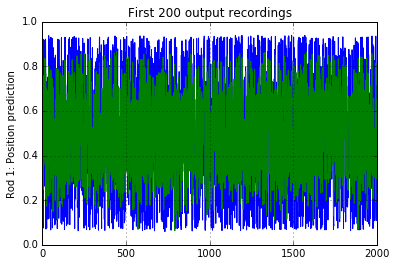

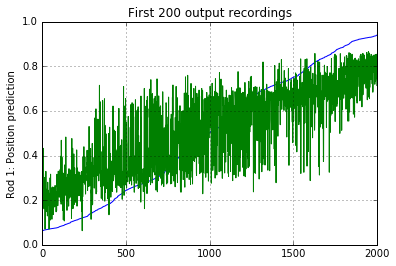

Wrote model to .\TwoBar\pos_cnn_weights_7.hdf
Epoch 9/9
1575/1575 [==============================] - 1060s - loss: 0.0341 - mse: 3.4110e-05 - val_loss: 0.0293 - val_mse: 2.9272e-05
Predicted.
array([[ 0.0517868 ],
       [ 0.41973901],
       [ 0.83397102],
       ..., 
       [ 0.876472  ],
       [ 0.113204  ],
       [ 0.40378499]], dtype=float32)
array([[ 0.03657955],
       [ 0.07900485],
       [ 0.85246873],
       ..., 
       [ 0.81096876],
       [ 0.13057944],
       [ 0.29253358]], dtype=float32)


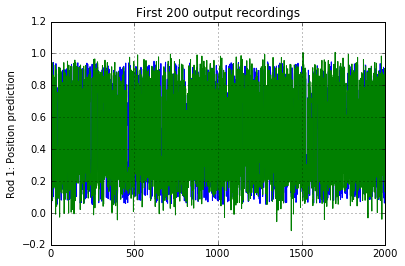

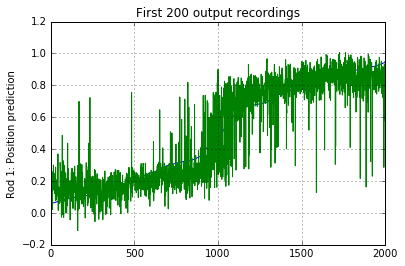

Wrote model to .\TwoBar\pos_cnn_weights_8.hdf
Epoch 10/10
 523/1575 [========>.....................] - ETA: 629s - loss: 0.0332 - mse: 3.3153e-05

In [ ]:

batch_size = 40

epoch = 0
(epoch, stop) = run_train2(model, batch_size, training, lr=0.0005,start_epoch=epoch, num_epochs=4, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=1)

(epoch, stop) = run_train(model, batch_size, training, lr=0.0005,start_epoch=epoch, num_epochs=10, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=1)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00005,start_epoch=epoch, num_epochs=10, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=4)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00001,start_epoch=epoch, num_epochs=10, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=4)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000001,start_epoch=epoch, num_epochs=50, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=4)

    # Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Position prediction")

In [7]:
# Load the best model result
epoch = 8
model.load_weights(WEIGHTS_FNAME % epoch, by_name=True)
print("Loaded model.")

Loaded model.


Starting at lr=0.000500
Batch size 40: 1575 training batches, 393 validation batches
Epoch 9/9
1575/1575 [==============================] - 1065s - loss: 0.0323 - mse: 3.2315e-05 - val_loss: 0.0274 - val_mse: 2.7420e-05
Predicted.
array([[ 0.0663712 ],
       [ 0.90002441],
       [ 0.69582403],
       ..., 
       [ 0.352153  ],
       [ 0.848014  ],
       [ 0.797939  ]], dtype=float32)
array([[ 0.26833868],
       [ 0.84071523],
       [ 0.69415069],
       ..., 
       [ 0.3714377 ],
       [ 0.78354776],
       [ 0.74970156]], dtype=float32)


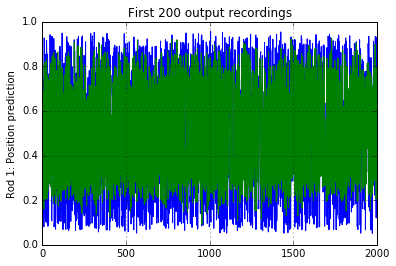

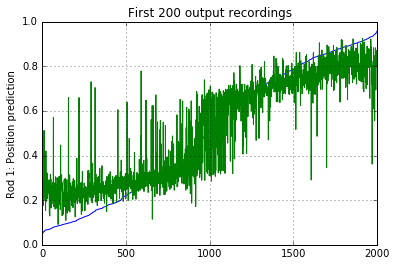

Wrote model to .\TwoBar\pos_cnn_weights_8.hdf
Epoch 10/10
1575/1575 [==============================] - 1067s - loss: 0.0310 - mse: 3.0973e-05 - val_loss: 0.0286 - val_mse: 2.8597e-05
Predicted.
array([[ 0.9336288 ],
       [ 0.90002441],
       [ 0.69582403],
       ..., 
       [ 0.352153  ],
       [ 0.151986  ],
       [ 0.797939  ]], dtype=float32)
array([[ 0.84967637],
       [ 0.90005261],
       [ 0.7215935 ],
       ..., 
       [ 0.34952614],
       [ 0.185332  ],
       [ 0.73558533]], dtype=float32)


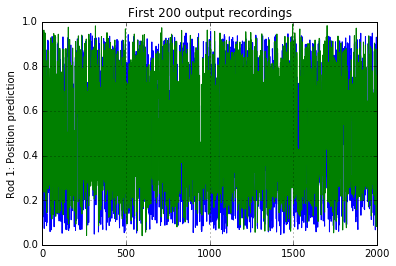

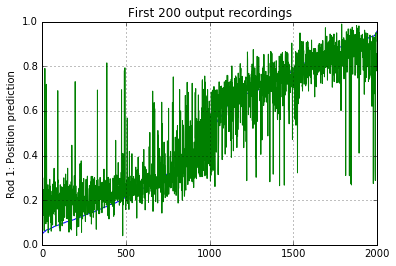

Wrote model to .\TwoBar\pos_cnn_weights_9.hdf
Epoch 11/11
1575/1575 [==============================] - 1081s - loss: 0.0296 - mse: 2.9598e-05 - val_loss: 0.0293 - val_mse: 2.9344e-05
Predicted.
array([[ 0.57860798],
       [ 0.92606401],
       [ 0.82105398],
       ..., 
       [ 0.92627299],
       [ 0.54767001],
       [ 0.535918  ]], dtype=float32)
array([[ 0.44854277],
       [ 0.90280223],
       [ 0.61969078],
       ..., 
       [ 0.84833193],
       [ 0.6520161 ],
       [ 0.55018246]], dtype=float32)


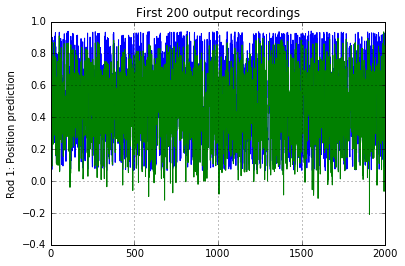

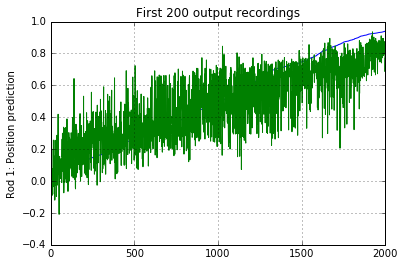

Wrote model to .\TwoBar\pos_cnn_weights_10.hdf
Epoch 12/12
1575/1575 [==============================] - 1122s - loss: 0.0284 - mse: 2.8450e-05 - val_loss: 0.0183 - val_mse: 1.8295e-05
Predicted.
array([[ 0.110877  ],
       [ 0.079042  ],
       [ 0.21268199],
       ..., 
       [ 0.73666698],
       [ 0.66925901],
       [ 0.232668  ]], dtype=float32)
array([[ 0.12155074],
       [ 0.20101024],
       [ 0.26124007],
       ..., 
       [ 0.81148255],
       [ 0.71277905],
       [ 0.3912603 ]], dtype=float32)


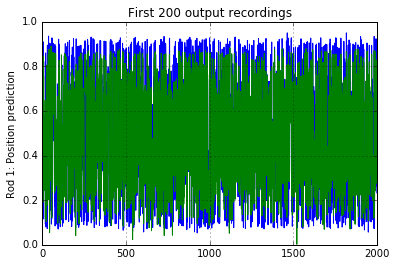

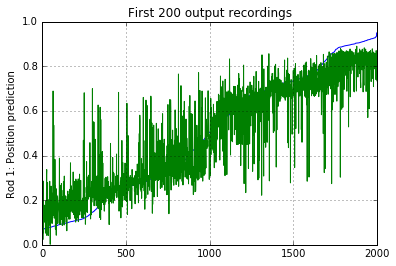

Wrote model to .\TwoBar\pos_cnn_weights_11.hdf
Epoch 13/13
1575/1575 [==============================] - 1086s - loss: 0.0273 - mse: 2.7320e-05 - val_loss: 0.0289 - val_mse: 2.8890e-05
Predicted.
array([[ 0.145666  ],
       [ 0.74965   ],
       [ 0.741808  ],
       ..., 
       [ 0.115415  ],
       [ 0.053713  ],
       [ 0.45206901]], dtype=float32)
array([[ 0.2951557 ],
       [ 0.50764978],
       [ 0.78797686],
       ..., 
       [ 0.11447638],
       [-0.02093324],
       [ 0.80489957]], dtype=float32)


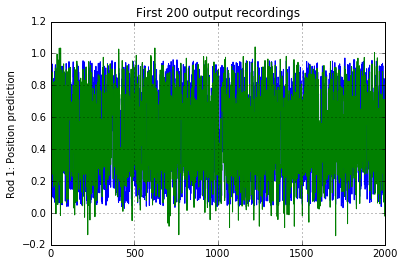

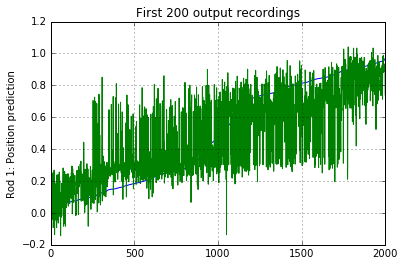

Wrote model to .\TwoBar\pos_cnn_weights_12.hdf
Epoch 14/14
1575/1575 [==============================] - 1220s - loss: 0.0272 - mse: 2.7159e-05 - val_loss: 0.0247 - val_mse: 2.4696e-05
Predicted.
array([[ 0.57860798],
       [ 0.073936  ],
       [ 0.178946  ],
       ..., 
       [ 0.073727  ],
       [ 0.54767001],
       [ 0.464082  ]], dtype=float32)
array([[ 0.50663441],
       [ 0.12807927],
       [ 0.45367244],
       ..., 
       [ 0.25834107],
       [ 0.70297766],
       [ 0.37509072]], dtype=float32)


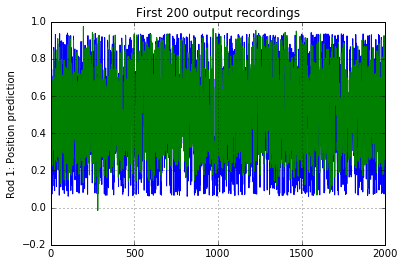

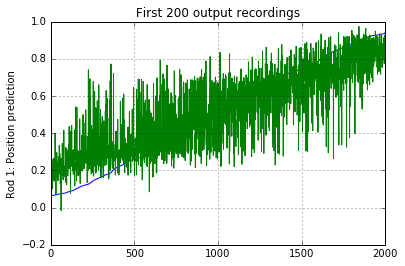

Wrote model to .\TwoBar\pos_cnn_weights_13.hdf
Epoch 15/15
   7/1575 [..............................] - ETA: 4187s - loss: 0.0286 - mse: 2.8612e-05
User stopped the training.
Predicted.
array([[ 0.88912302],
       [ 0.079042  ],
       [ 0.78731799],
       ..., 
       [ 0.26333299],
       [ 0.33074099],
       [ 0.232668  ]], dtype=float32)
array([[ 0.86041784],
       [ 0.2598666 ],
       [ 0.7303369 ],
       ..., 
       [ 0.20787948],
       [ 0.28714257],
       [ 0.29450285]], dtype=float32)


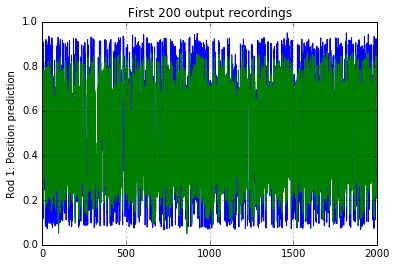

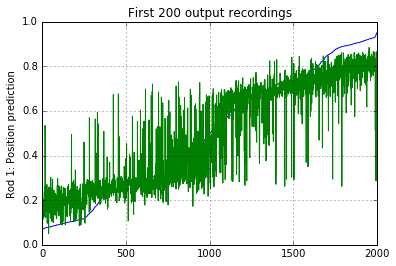

In [8]:

batch_size = 40

(epoch, stop) = run_train(model, batch_size, training, lr=0.0005,start_epoch=epoch, num_epochs=10, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=1)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00005,start_epoch=epoch, num_epochs=10, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=4)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.00001,start_epoch=epoch, num_epochs=10, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=4)
if not stop:
    (epoch, stop) = run_train(model, batch_size, training, lr=0.000001,start_epoch=epoch, num_epochs=50, WEIGHTS_FNAME=WEIGHTS_FNAME, MODELS_FNAME=MODELS_FNAME, plot_frequency=4)

# Plot the real versus predicted values for some of the validation data
plot_validate(ValidateBatchGen(batch_size, model, training), model, 2000, "Position prediction")